In [1]:
pip install pandas numpy matplotlib seaborn faker openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 42.7 MB/s eta 0:00:00


In [2]:
from google.colab import files

uploaded = files.upload()  # Select your CSV or ZIP file


Saving billing_updated.csv to billing_updated.csv
Saving diagnoses_updated.csv to diagnoses_updated.csv
Saving encounters_updated.csv to encounters_updated.csv
Saving facilities_updated.csv to facilities_updated.csv
Saving lab_results_updated.csv to lab_results_updated.csv
Saving medication_orders_updated.csv to medication_orders_updated.csv
Saving patients_updated.csv to patients_updated.csv
Saving providers_updated.csv to providers_updated.csv


In [3]:
import pandas as pd

# Load individual CSV files (updated versions)
patients = pd.read_csv("patients_updated.csv")
facilities = pd.read_csv("facilities_updated.csv")
encounters = pd.read_csv("encounters_updated.csv")
diagnoses = pd.read_csv("diagnoses_updated.csv")
lab_results = pd.read_csv("lab_results_updated.csv")
med_orders = pd.read_csv("medication_orders_updated.csv")
providers = pd.read_csv("providers_updated.csv")
billing = pd.read_csv("billing_updated.csv")

# Quick check
print("Patients:", patients.shape)
print("Facilities:", facilities.shape)
print("Encounters:", encounters.shape)
print("Diagnoses:", diagnoses.shape)
print("Lab Results:", lab_results.shape)
print("Medication Orders:", med_orders.shape)
print("Providers:", providers.shape)
print("Billing:", billing.shape)


Patients: (3000, 6)
Facilities: (10, 6)
Encounters: (10000, 9)
Diagnoses: (5000, 5)
Lab Results: (15000, 5)
Medication Orders: (10000, 5)
Providers: (50, 6)
Billing: (10000, 7)


In [4]:
# -----------------------------
# 2. INITIAL EXPLORATION
# -----------------------------
def explore_table(df, name):
    print(f"--- {name} ---")
    print("Shape:", df.shape)
    print("Columns:", df.columns.tolist())
    print("Data Types:\n", df.dtypes)
    print("Missing Values:\n", df.isnull().sum())
    print(df.describe(include='all').T)
    print("\n\n")

tables = [patients, facilities, encounters, diagnoses, lab_results, med_orders, providers, billing]
names = ["Patients", "Facilities", "Encounters", "Diagnoses", "Lab Results", "Medications", "Providers", "Billing"]

for t, n in zip(tables, names):
    explore_table(t, n)

# -----------------------------
# 3. DATA CLEANING
# -----------------------------

# --- Patients ---
patients['age'] = patients['age'].fillna(patients['age'].median())
patients['age'] = patients['age'].astype(int)

# Remove outliers in age (<0 or >100)
patients = patients[(patients['age'] >= 0) & (patients['age'] <= 100)]

# --- Facilities ---
# Fill missing quality_rating with median
facilities['quality_rating'] = facilities['quality_rating'].fillna(facilities['quality_rating'].median())

# Clip to valid range 1-5
facilities['quality_rating'] = facilities['quality_rating'].clip(1,5)

# --- Providers ---
providers['years_experience'] = providers['years_experience'].fillna(0).astype(int)

# Remove extreme outliers (>50 years experience)
providers = providers[providers['years_experience'] <= 50]

# --- Encounters ---
encounters['admission_date'] = pd.to_datetime(encounters['admission_date'])
encounters['discharge_date'] = pd.to_datetime(encounters['discharge_date'])
encounters['length_of_stay'] = encounters['length_of_stay'].fillna(encounters['length_of_stay'].median())

# Remove negative or extreme LOS (>60 days)
encounters = encounters[(encounters['length_of_stay'] > 0) & (encounters['length_of_stay'] <= 60)]

# --- Billing ---
billing['total_charges'] = billing['total_charges'].fillna(billing['total_charges'].median())
billing['insurance_paid'] = billing['insurance_paid'].fillna(0)
billing['patient_pay'] = billing['patient_pay'].fillna(0)
billing['adjustment_amount'] = billing['adjustment_amount'].fillna(0)

# Remove extreme outliers (total_charges > 100000)
billing = billing[billing['total_charges'] <= 100000]

# --- Lab Results ---
lab_results['result_value'] = lab_results['result_value'].fillna(lab_results['result_value'].median())
# Remove extreme outliers (>3 std dev)
lab_mean = lab_results['result_value'].mean()
lab_std = lab_results['result_value'].std()
lab_results = lab_results[(lab_results['result_value'] >= lab_mean - 3*lab_std) &
                          (lab_results['result_value'] <= lab_mean + 3*lab_std)]

# --- Medications ---
med_orders['dose'] = med_orders['dose'].fillna(med_orders['dose'].median())
# Remove extreme doses (>3 std dev)
dose_mean = med_orders['dose'].mean()
dose_std = med_orders['dose'].std()
med_orders = med_orders[(med_orders['dose'] >= dose_mean - 3*dose_std) &
                        (med_orders['dose'] <= dose_mean + 3*dose_std)]

# -----------------------------
# 4. QUICK CHECK AFTER CLEANING
# -----------------------------
for t, n in zip([patients, facilities, encounters, diagnoses, lab_results, med_orders, providers, billing], names):
    print(f"{n} cleaned shape: {t.shape}")

--- Patients ---
Shape: (3000, 6)
Columns: ['patient_id', 'patient_name', 'age', 'gender', 'ethnicity', 'registration_date']
Data Types:
 patient_id           object
patient_name         object
age                   int64
gender               object
ethnicity            object
registration_date    object
dtype: object
Missing Values:
 patient_id           0
patient_name         0
age                  0
gender               0
ethnicity            0
registration_date    0
dtype: int64
                    count unique                                   top  freq  \
patient_id           3000   3000  8264f8be-ef37-40aa-8e3c-e064405e4119     1   
patient_name         3000   2942                        Richard Walker     3   
age                3000.0    NaN                                   NaN   NaN   
gender               3000      3                                  Male  1481   
ethnicity            3000      5                                 White  1471   
registration_date    3000   2030

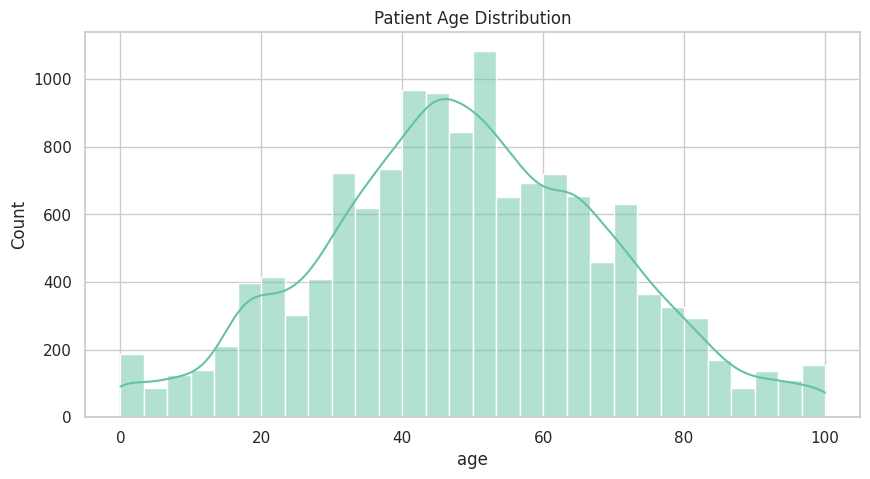

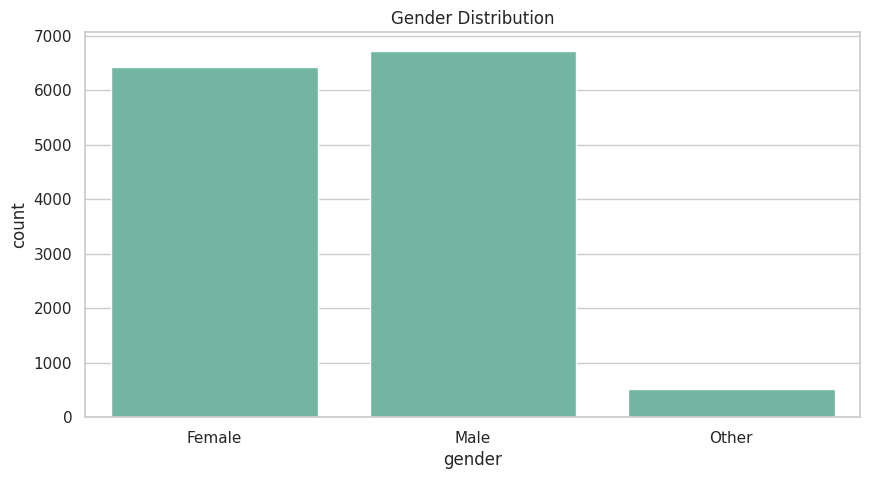

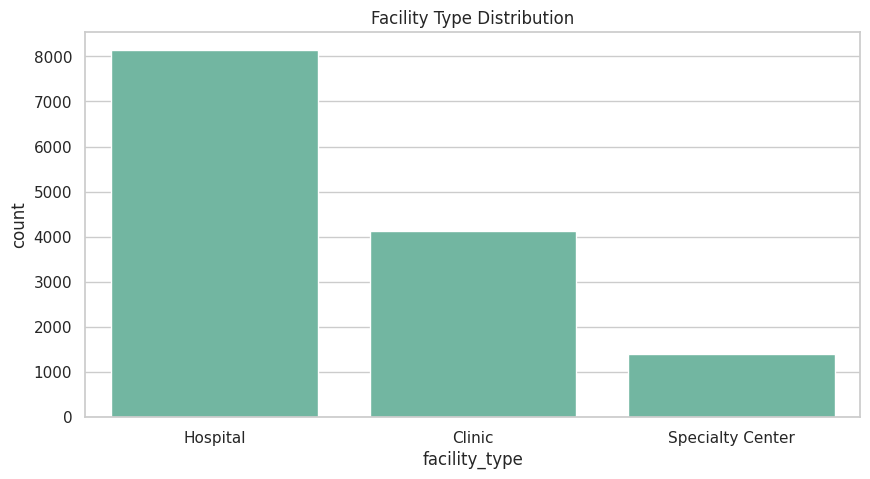

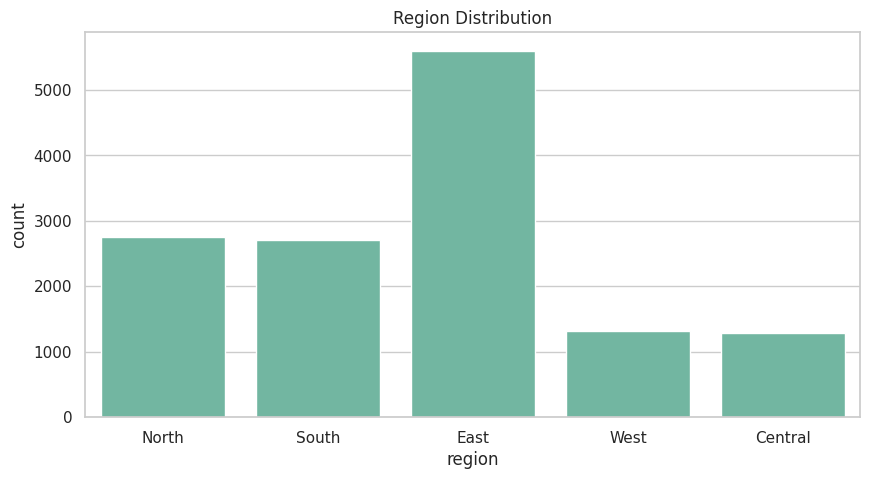

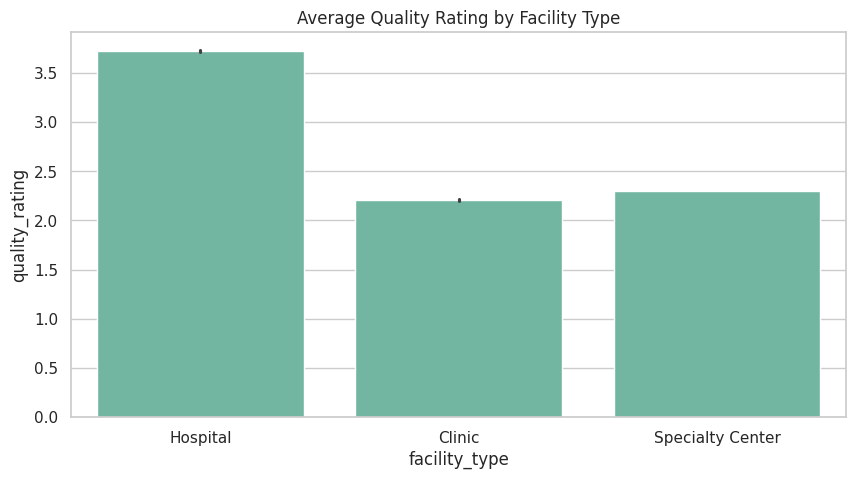

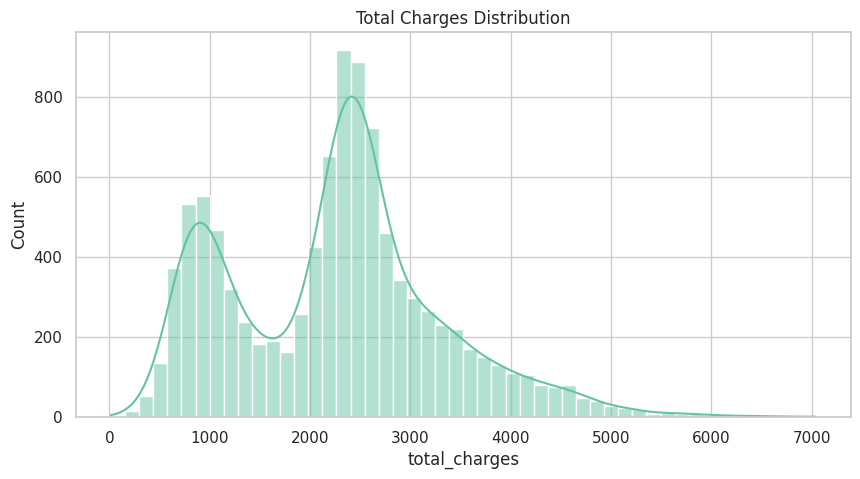

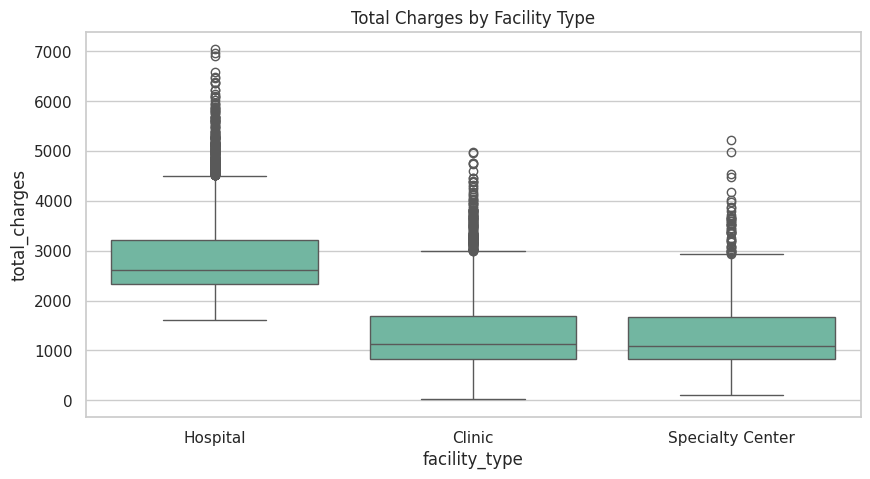

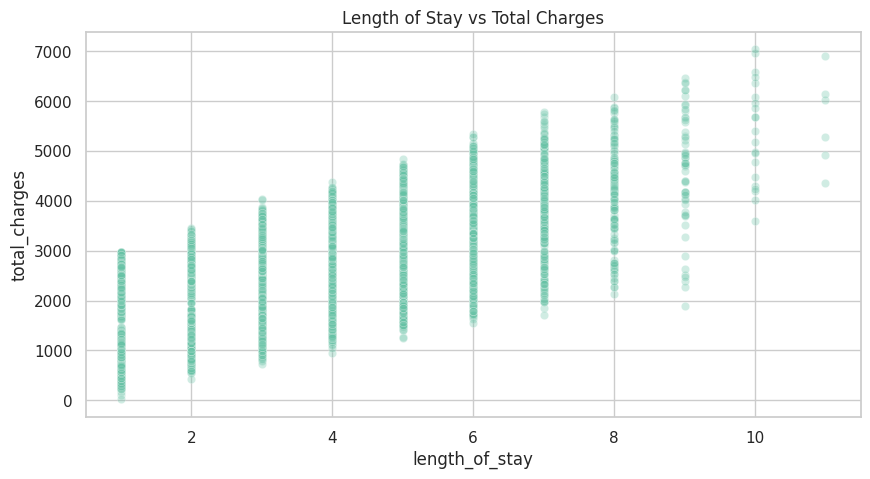

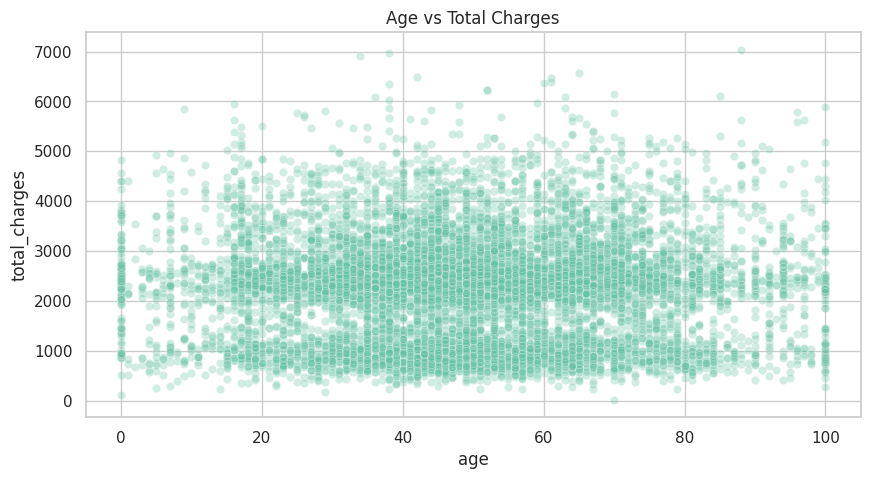

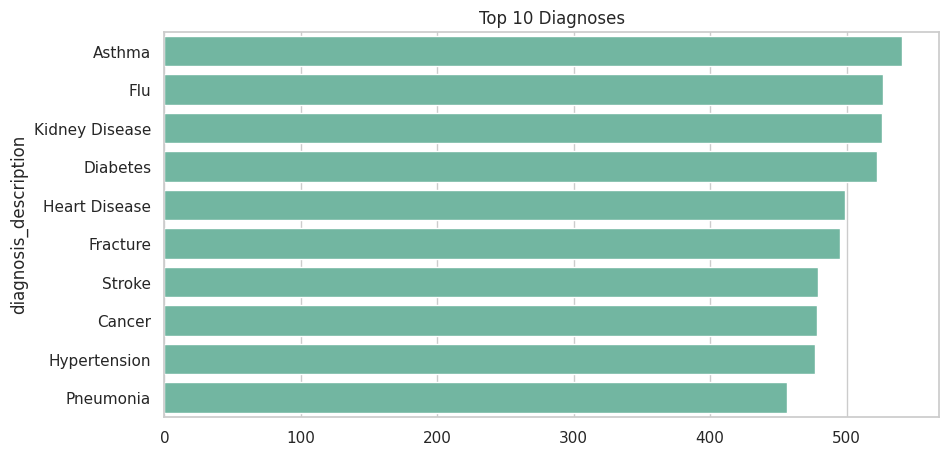

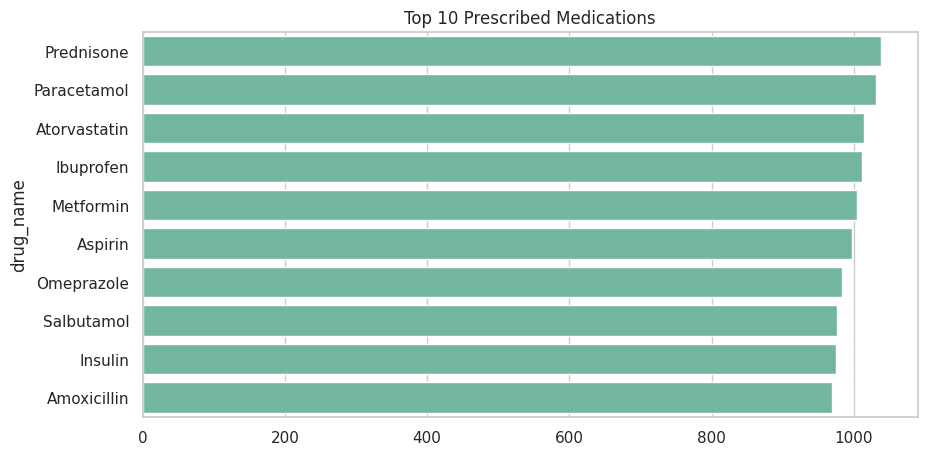

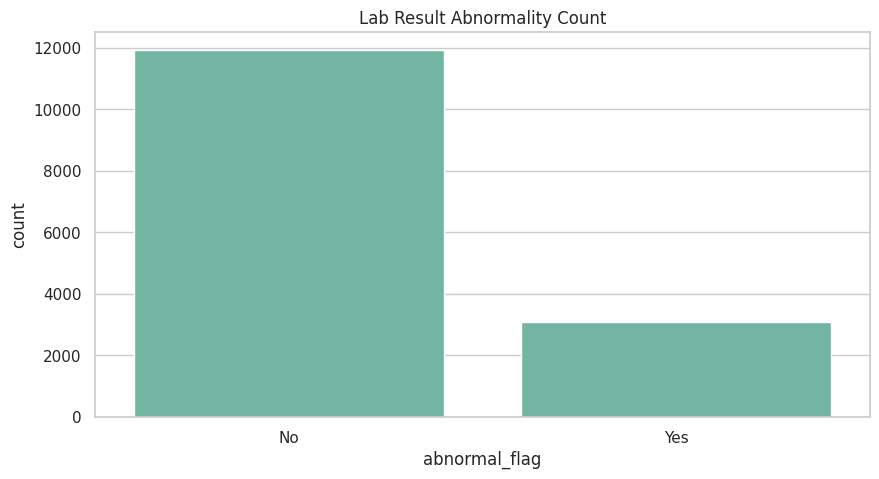

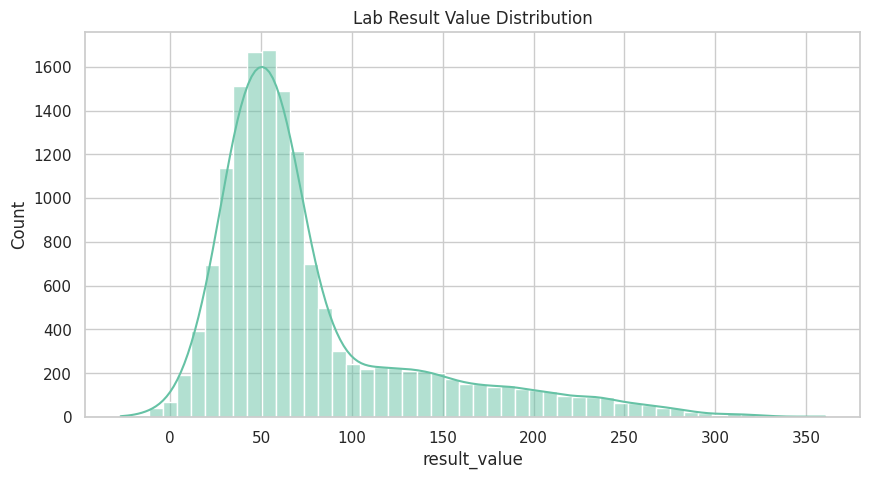

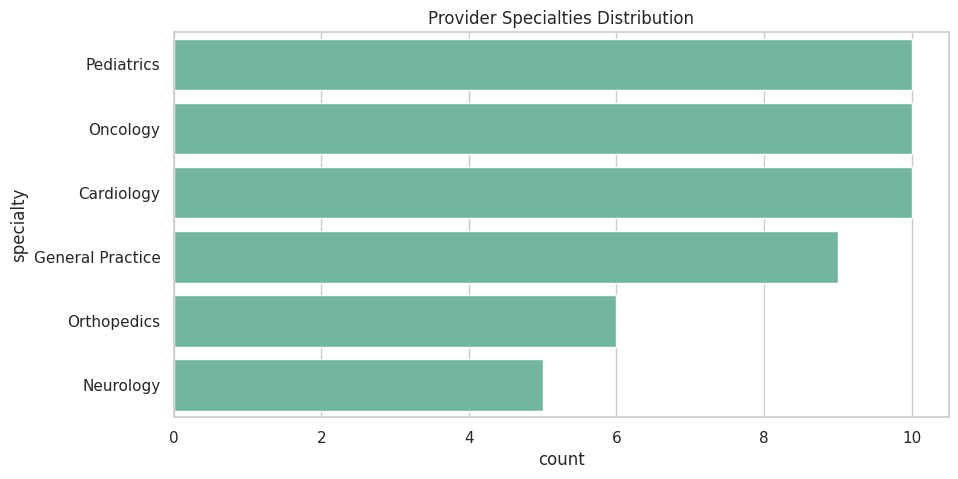

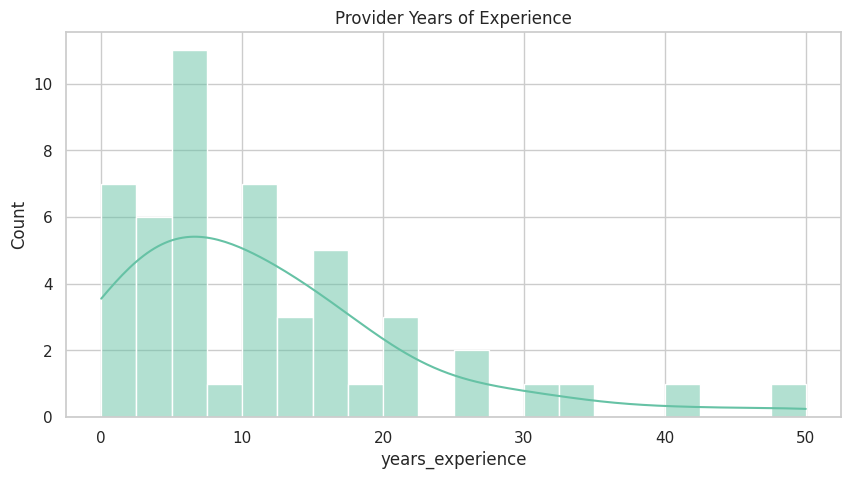

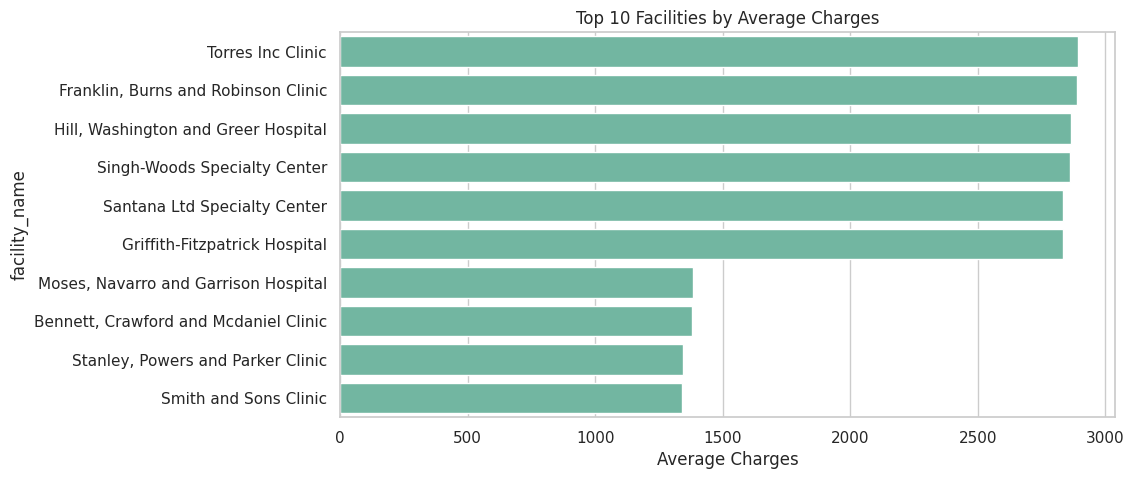

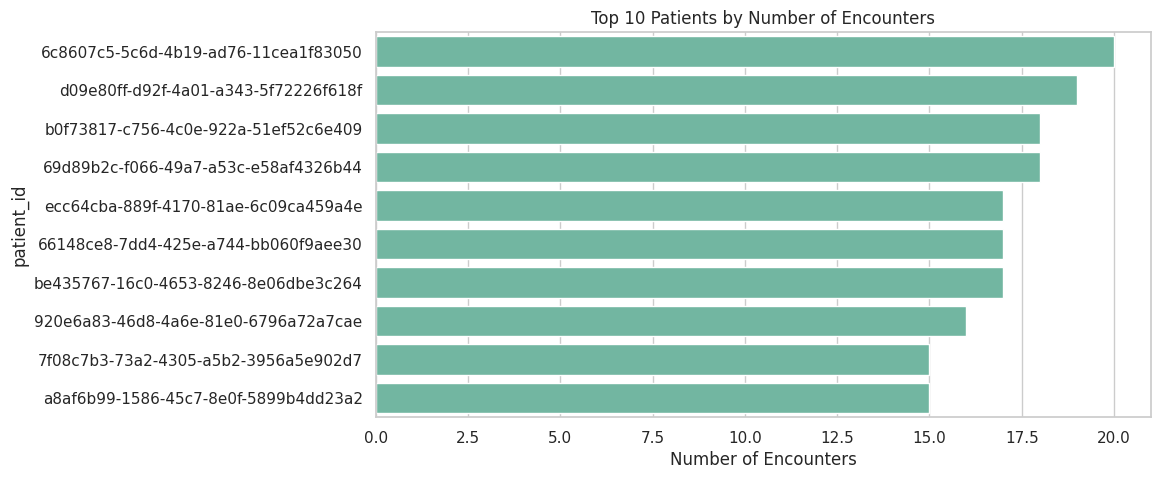

In [6]:
# --------------------------
# 1. IMPORT LIBRARIES
# --------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10,5)
palette = sns.color_palette("Set2")
sns.set_palette(palette)
%matplotlib inline



# --------------------------
# 4. MERGE DATA FOR ANALYSIS
# --------------------------
df = encounters.merge(patients, on='patient_id', how='left')\
               .merge(facilities, on='facility_id', how='left')\
               .merge(providers[['provider_id','specialty']], on='provider_id', how='left')\
               .merge(billing, on='encounter_id', how='left')

# --------------------------
# 5. UNIVARIATE ANALYSIS
# --------------------------

# Patient Age Distribution
sns.histplot(df['age'], bins=30, kde=True)
plt.title("Patient Age Distribution")
plt.show()

# Gender Distribution
sns.countplot(x='gender', data=df)
plt.title("Gender Distribution")
plt.show()

# Facility Types
sns.countplot(x='facility_type', data=df)
plt.title("Facility Type Distribution")
plt.show()

# Region Distribution
sns.countplot(x='region', data=df)
plt.title("Region Distribution")
plt.show()

# Quality Rating by Facility Type
sns.barplot(x='facility_type', y='quality_rating', data=df, estimator='mean')
plt.title("Average Quality Rating by Facility Type")
plt.show()

# --------------------------
# 6. BILLING & COST ANALYSIS
# --------------------------
# Total Charges Distribution
sns.histplot(df['total_charges'], bins=50, kde=True)
plt.title("Total Charges Distribution")
plt.show()

# Charges by Facility Type
sns.boxplot(x='facility_type', y='total_charges', data=df)
plt.title("Total Charges by Facility Type")
plt.show()

# Length of Stay vs Total Charges
sns.scatterplot(x='length_of_stay', y='total_charges', data=df, alpha=0.3)
plt.title("Length of Stay vs Total Charges")
plt.show()

# Age vs Total Charges
sns.scatterplot(x='age', y='total_charges', data=df, alpha=0.3)
plt.title("Age vs Total Charges")
plt.show()

# --------------------------
# 7. DIAGNOSES & MEDICATIONS
# --------------------------
# Top 10 Diagnoses
top_diag = diagnoses['diagnosis_description'].value_counts().head(10)
sns.barplot(x=top_diag.values, y=top_diag.index)
plt.title("Top 10 Diagnoses")
plt.show()

# Top 10 Medications
top_med = med_orders['drug_name'].value_counts().head(10)
sns.barplot(x=top_med.values, y=top_med.index)
plt.title("Top 10 Prescribed Medications")
plt.show()

# --------------------------
# 8. LAB RESULTS
# --------------------------
# Abnormal Lab Counts
sns.countplot(x='abnormal_flag', data=lab_results)
plt.title("Lab Result Abnormality Count")
plt.show()

# Lab Result Distribution
sns.histplot(lab_results['result_value'], bins=50, kde=True)
plt.title("Lab Result Value Distribution")
plt.show()

# --------------------------
# 9. PROVIDER ANALYSIS
# --------------------------
# Specialty Distribution
sns.countplot(y='specialty', data=providers, order=providers['specialty'].value_counts().index)
plt.title("Provider Specialties Distribution")
plt.show()

# Years of Experience
sns.histplot(providers['years_experience'], bins=20, kde=True)
plt.title("Provider Years of Experience")
plt.show()

# --------------------------
# 10. ADVANCED INSIGHTS
# --------------------------
# Top Facilities by Average Charges
top_facilities = df.groupby('facility_name')['total_charges'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=top_facilities.values, y=top_facilities.index)
plt.title("Top 10 Facilities by Average Charges")
plt.xlabel("Average Charges")
plt.show()

# High-utilizer Patients
top_patients = df['patient_id'].value_counts().head(10)
sns.barplot(x=top_patients.values, y=top_patients.index)
plt.title("Top 10 Patients by Number of Encounters")
plt.xlabel("Number of Encounters")
plt.show()
